<h1><center>GLM Site 11</center></h1>


### Import all the packages that we need 

In [2]:
options(warn = -1)
library(caret)
library(dplyr)
library(corrplot)
library(DMwR)
library(unbalanced)
library(ROCR)
library(pROC)
library(boot)

### Set working directory and load data

In [20]:
setwd("/Users/sunmengnan/Documents/Github2/thgfd/data/stratified")
glm_data <- read.csv("dataset_11.csv")
glm_data$fraud_status <- as.factor((glm_data$fraud_status))
glm_data <- select(glm_data, -Site_Key, -Ordered_Product_Key)
head(glm_data)

Category_Level_2Accessories,Category_Level_2Bags,Category_Level_2Beauty.Boxes,Category_Level_2Body.Care,Category_Level_2Books,Category_Level_2Clothing,Category_Level_2DVD.and.Blu.Ray,Category_Level_2Footwear,Category_Level_2Fragrance,Category_Level_2Games,⋯,num_valid,count,prop,customer_status,canc_prop,ship_status,fraud_status,destination_int,priority_int,occupation_int
0,0,0,0,0,0,0,1,0,0,⋯,1,1,1,2,0,1,0,2,2,1
0,0,0,0,0,0,0,1,0,0,⋯,1,1,1,2,0,1,0,2,2,1
0,0,0,0,0,0,0,1,0,0,⋯,0,2,0,3,1,1,0,1,1,1
0,0,0,0,0,0,0,1,0,0,⋯,2,2,1,2,0,1,0,1,1,1
0,0,0,0,0,0,0,1,0,0,⋯,2,2,1,2,0,1,0,1,1,1
0,0,0,0,0,0,0,1,0,0,⋯,0,2,0,3,1,1,0,2,1,1


### Show the fraud status table

In [21]:
table(glm_data$fraud_status)


   0    1 
8600  146 

### Firstly, in the data cleaning process, use the Tlink to find the nearest point between fraud and non-fraud instance, which should be considered as noise and remove these data, show the sum of fraud counts, the number decreases

In [23]:
set.seed(123)
Tomek <- ubTomek(select(glm_data, -fraud_status), glm_data$fraud_status, verbose = TRUE)
glm_data <- cbind(Tomek$X, Tomek$Y)
glm_data <- rename(glm_data, fraud_status = "Tomek$Y")
head(glm_data)
table(glm_data$fraud_status)

Instances removed 64 : 0.75 % of 0 class ; 0.74 % of training ; Time needed 0.02 


Category_Level_2Accessories,Category_Level_2Bags,Category_Level_2Beauty.Boxes,Category_Level_2Body.Care,Category_Level_2Books,Category_Level_2Clothing,Category_Level_2DVD.and.Blu.Ray,Category_Level_2Footwear,Category_Level_2Fragrance,Category_Level_2Games,⋯,num_valid,count,prop,customer_status,canc_prop,ship_status,destination_int,priority_int,occupation_int,fraud_status
0,0,0,0,0,0,0,1,0,0,⋯,1,1,1,2,0,1,2,2,1,0
0,0,0,0,0,0,0,1,0,0,⋯,1,1,1,2,0,1,2,2,1,0
0,0,0,0,0,0,0,1,0,0,⋯,0,2,0,3,1,1,1,1,1,0
0,0,0,0,0,0,0,1,0,0,⋯,2,2,1,2,0,1,1,1,1,0
0,0,0,0,0,0,0,1,0,0,⋯,2,2,1,2,0,1,1,1,1,0
0,0,0,0,0,0,0,1,0,0,⋯,0,2,0,3,1,1,2,1,1,0



   0    1 
8464  146 

### select the data that we want to turn into factor type, turn all the variable type into factor, keep the factor which has more than two factor levels, then combine them together again

In [24]:
temp <- select(glm_data, -prop, -canc_prop, -Product_Charge_Price, -num_valid, 
               -count, -Order_Sequence_No, -Ordered_Qty, -Cancelled_Qty)
temp[,(1:ncol(temp))] <- lapply(temp[,(1:ncol(temp))],as.factor)
temp <- temp[, sapply(temp, nlevels) > 1]
nums <- select(glm_data, prop, canc_prop, Product_Charge_Price, num_valid, 
               count, Order_Sequence_No, Ordered_Qty, Cancelled_Qty)
glm_data <- cbind(temp, nums)

### Omitting some conlumns which we do not need and view that top rows of the data 

In [25]:
glm_data <- select(glm_data, -Campaign_Key, -Delivery_Option_Type_Key, -Payment_Method_Key,
                   -Medium_Key, -pay_key_num, -Payment_Provider_Key, 
                   -Order_Payment_Status_Key, -occupation_int,
                   -canc_prop, -Ordered_Qty, -priority_int, -Cancelled_Qty, -prop,
                   -Order_Sequence_No, -count)


In [26]:
glm_data <- select(glm_data, -Category_Level_2Accessories, 
                   -Category_Level_2Bags, -Category_Level_2Gifting)


In [27]:
new_data <- glm_data


### Create a partition to seperate the data into training part and test part


In [28]:
set.seed(123)
index <- createDataPartition(glm_data$fraud_status, p = 0.7, list = FALSE)
train <- new_data[index, ]
test <- new_data[-index, ]

### Train our model using SOMTE, in each iteration, samples one minority class element , then one of its nearest neighbors. Both points are now interpolated / convex-combined, resulting in a new virtual data point for the minority class, we compare the two tables before and after SOMTE, we can see that the fraud transaction times enlarge by 10 times


In [35]:
set.seed(123)
train <- SMOTE(fraud_status ~., new_data, perc.over = 1000, perc.under = 150)
table(new_data$fraud_status)
prop.table(table(new_data$fraud_status))
table(train$fraud_status)
prop.table(table(train$fraud_status))


   0    1 
8464  146 


         0          1 
0.98304297 0.01695703 


   0    1 
2190 1606 


        0         1 
0.5769231 0.4230769 

### Bulid a GLM model, using binomial logit link function, and also calculate the running time

In [13]:
start <- Sys.time()
model <- glm(fraud_status ~., data = train, family = binomial(link = "logit"))
end <- Sys.time()
time <- end - start
time
summary(model)

Time difference of 0.05064011 secs


Call:
glm(formula = fraud_status ~ ., family = binomial(link = "logit"), 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.0321  -0.4750  -0.3227   0.2569   3.5294  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                5.112165   0.252882  20.216  < 2e-16 ***
Category_Level_2Clothing1  2.954720   0.197469  14.963  < 2e-16 ***
Category_Level_2Footwear1 -2.721310   0.170857 -15.927  < 2e-16 ***
customer_status2          -3.402626   0.167737 -20.286  < 2e-16 ***
customer_status3          -3.180352   0.247008 -12.876  < 2e-16 ***
customer_status4          -1.468917   0.188669  -7.786 6.93e-15 ***
ship_status2               0.506519   0.158377   3.198  0.00138 ** 
destination_int2          -0.573440   0.109921  -5.217 1.82e-07 ***
Product_Charge_Price      -0.017966   0.001869  -9.613  < 2e-16 ***
num_valid                  0.020605   0.011167   1.845  0.06500 .  
---
Signif. codes:  0 ‘***’ 0.

### Then, choose a model by AIC in a Stepwise Algorithm, in this process, we gradually delete 2footwear, charge price and ship status, because these variables AIC are lower than others


In [14]:
model <- step(model)
summary(model)


Start:  AIC=2397.78
fraud_status ~ Category_Level_2Clothing + Category_Level_2Footwear + 
    customer_status + ship_status + destination_int + Product_Charge_Price + 
    num_valid

                           Df Deviance    AIC
<none>                          2377.8 2397.8
- num_valid                 1   2380.8 2398.8
- ship_status               1   2387.8 2405.8
- destination_int           1   2405.1 2423.1
- Product_Charge_Price      1   2490.5 2508.5
- Category_Level_2Clothing  1   2709.7 2727.7
- Category_Level_2Footwear  1   2713.9 2731.9
- customer_status           3   3046.7 3060.7



Call:
glm(formula = fraud_status ~ Category_Level_2Clothing + Category_Level_2Footwear + 
    customer_status + ship_status + destination_int + Product_Charge_Price + 
    num_valid, family = binomial(link = "logit"), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.0321  -0.4750  -0.3227   0.2569   3.5294  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                5.112165   0.252882  20.216  < 2e-16 ***
Category_Level_2Clothing1  2.954720   0.197469  14.963  < 2e-16 ***
Category_Level_2Footwear1 -2.721310   0.170857 -15.927  < 2e-16 ***
customer_status2          -3.402626   0.167737 -20.286  < 2e-16 ***
customer_status3          -3.180352   0.247008 -12.876  < 2e-16 ***
customer_status4          -1.468917   0.188669  -7.786 6.93e-15 ***
ship_status2               0.506519   0.158377   3.198  0.00138 ** 
destination_int2          -0.573440   0.109921  -5.217 1.82e-07 ***
Product_Charge_Price      

### We delete the first clothing variable then, and see the model evaluation, it's more significant for all the variables

In [15]:
model <- update(model, .~. -Category_Level_2Clothing-Category_Level_2Footwear)
summary(model)


Call:
glm(formula = fraud_status ~ customer_status + ship_status + 
    destination_int + Product_Charge_Price + num_valid, family = binomial(link = "logit"), 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8775  -0.6719  -0.3616   0.5392   4.0284  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           4.076222   0.193282  21.090  < 2e-16 ***
customer_status2     -3.748983   0.161387 -23.230  < 2e-16 ***
customer_status3     -3.138873   0.207338 -15.139  < 2e-16 ***
customer_status4     -1.558727   0.178529  -8.731  < 2e-16 ***
ship_status2          0.611844   0.131570   4.650 3.31e-06 ***
destination_int2     -0.662527   0.090870  -7.291 3.08e-13 ***
Product_Charge_Price -0.029968   0.001708 -17.541  < 2e-16 ***
num_valid             0.015923   0.010424   1.528    0.127    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)


### Use our model to test our test data set, calculate the curve area value

[1] 0.7805426

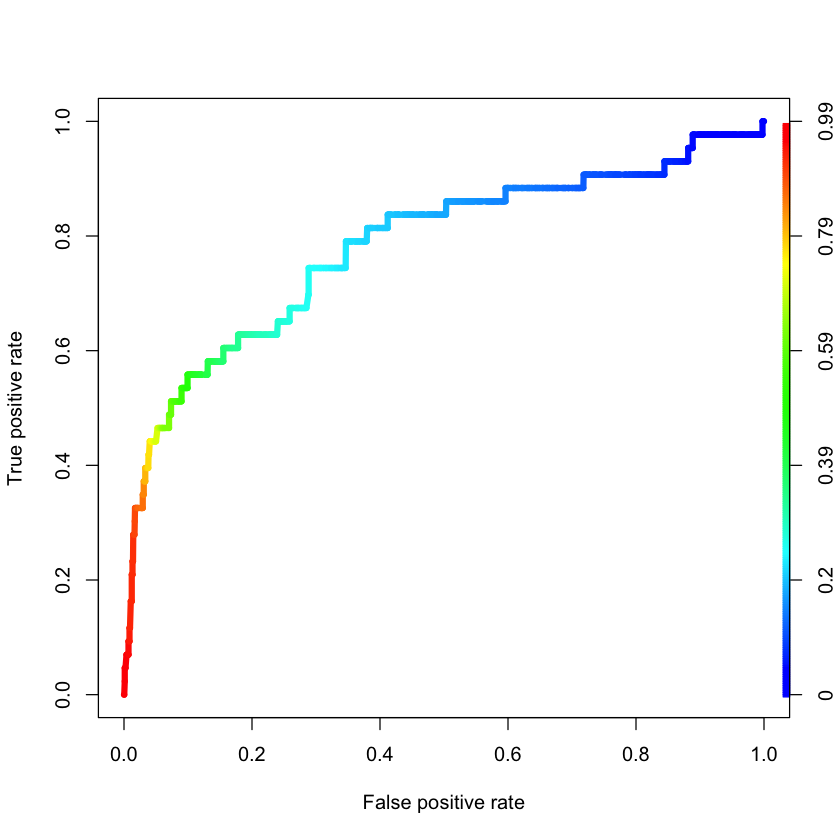

In [16]:
model_predict <- predict(model, test, type = "response")
ROC_predict <- prediction(model_predict, test$fraud_status)
ROC_performance <- performance(ROC_predict, "tpr", "fpr")
plot(ROC_performance, colorize = TRUE, text.adj = c(-0.2,1.7), lwd = 5)
area_under_curve <- performance(ROC_predict, measure = "auc")
area_under_curve@y.values[[1]]

### Set training control parameter and use this model to predict the fraud status, ouput  the confusion matrix as well

In [17]:
ctrl <- trainControl(method = "repeatedcv", number = 10, savePredictions = TRUE)
model_fit <- caret::train(fraud_status ~ customer_status + ship_status + destination_int + 
                     Product_Charge_Price + num_valid,
                   data = train, method = "glm", family = binomial(link ="logit"),
                   trControl = ctrl, tuneLength = 10)
pred <- predict(model_fit, newdata = select(test, -fraud_status))
conf <- confusionMatrix(data = pred, test$fraud_status)
conf
conf$byClass

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2308   20
         1  250   23
                                          
               Accuracy : 0.8962          
                 95% CI : (0.8838, 0.9077)
    No Information Rate : 0.9835          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1204          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.90227         
            Specificity : 0.53488         
         Pos Pred Value : 0.99141         
         Neg Pred Value : 0.08425         
             Prevalence : 0.98347         
         Detection Rate : 0.88735         
   Detection Prevalence : 0.89504         
      Balanced Accuracy : 0.71858         
                                          
       'Positive' Class : 0               
                                          

Sensitivity          Specificity       Pos Pred Value 
          0.90226740           0.53488372           0.99140893 
      Neg Pred Value            Precision               Recall 
          0.08424908           0.99140893           0.90226740 
                  F1           Prevalence       Detection Rate 
          0.94474007           0.98346790           0.88735102 
Detection Prevalence    Balanced Accuracy 
          0.89504037           0.71857556